In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    ''' 
    Смесь двух гауссовых распределений - интересный пример для тестирования MCMC,
    так как алгоритмы должны уметь исследовать несколько мод распределения.
    
    p(x) = 0.5 * N(μ1, I) + 0.5 * N(μ2, I)
    где μ1 = [-2, -2, ..., -2] и μ2 = [2, 2, ..., 2]
    '''
    d = len(x)
    mu1 = np.ones(d) * -2.0
    mu2 = np.ones(d) * 2.0

    logp1 = -0.5 * np.dot(x - mu1, x - mu1)
    logp2 = -0.5 * np.dot(x - mu2, x - mu2)

    max_logp = max(logp1, logp2)
    logp_mixture = max_logp + np.log(0.5 * np.exp(logp1 - max_logp) + 
                                      0.5 * np.exp(logp2 - max_logp))

    p1 = np.exp(logp1 - max_logp)
    p2 = np.exp(logp2 - max_logp)
    grad_logp1 = -(x - mu1)
    grad_logp2 = -(x - mu2)

    p_total = 0.5 * p1 + 0.5 * p2
    w1 = 0.5 * p1 / p_total
    w2 = 0.5 * p2 / p_total
    
    grad_logp_mixture = w1 * grad_logp1 + w2 * grad_logp2
    
    return logp_mixture, grad_logp_mixture

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad_x = grad_logp(x)
        
        epsilon = rng.normal(0, 1, size=d)
        prop = x + step * grad_x + np.sqrt(2 * step) * epsilon

        grad_prop = grad_logp(prop)
        
        diff_forward = prop - x - step * grad_x
        log_q_prop_given_x = -0.5 * np.dot(diff_forward, diff_forward) / (2 * step)

        diff_backward = x - prop - step * grad_prop
        log_q_x_given_prop = -0.5 * np.dot(diff_backward, diff_backward) / (2 * step)
        
        log_accept = (logp(prop) - logp(x) + 
                     log_q_x_given_prop - log_q_prop_given_x)
        
        if np.log(rng.uniform()) < log_accept:
            x = prop
            accept += 1
        
        chain[t] = x

    return chain, accept / steps

In [6]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3

mala_step = 0.2
mh_scale = 1.5

print("Запуск MH алгоритма...")
mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
print(f"MH acceptance rate: {mh_acc:.4f}")

print("Запуск MALA алгоритма...")
mala_chain, mala_acc = mala(x0, steps, step=mala_step)
print(f"MALA acceptance rate: {mala_acc:.4f}")

mh_chain_burned = mh_chain[burn:]
mala_chain_burned = mala_chain[burn:]

mh_ess_per_dim = np.array([ess(mh_chain_burned[:, i]) for i in range(d)])
mala_ess_per_dim = np.array([ess(mala_chain_burned[:, i]) for i in range(d)])

mh_median_ess = np.median(mh_ess_per_dim)
mala_median_ess = np.median(mala_ess_per_dim)

print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ:")
print("="*50)
print(f"MH:")
print(f"  Acceptance rate: {mh_acc:.4f}")
print(f"  Медианный ESS: {mh_median_ess:.2f}")
print(f"  ESS по размерностям: {mh_ess_per_dim}")
print(f"\nMALA:")
print(f"  Acceptance rate: {mala_acc:.4f}")
print(f"  Медианный ESS: {mala_median_ess:.2f}")
print(f"  ESS по размерностям: {mala_ess_per_dim}")
print("="*50)

Запуск MH алгоритма...
MH acceptance rate: 0.0430
Запуск MALA алгоритма...
MALA acceptance rate: 0.9181

РЕЗУЛЬТАТЫ:
MH:
  Acceptance rate: 0.0430
  Медианный ESS: 301.45
  ESS по размерностям: [363.75174067 240.73725559 295.32200819 295.84826306 305.10635982
 297.80068153 241.28056982 426.36989686 373.31064204 312.73058685]

MALA:
  Acceptance rate: 0.9181
  Медианный ESS: 2649.68
  ESS по размерностям: [2345.61366352 2596.33984448 3676.98460621 2659.00218248 2624.27170513
 3398.61498463 2640.35737524 4435.02118611 2233.15718394 2865.4350295 ]


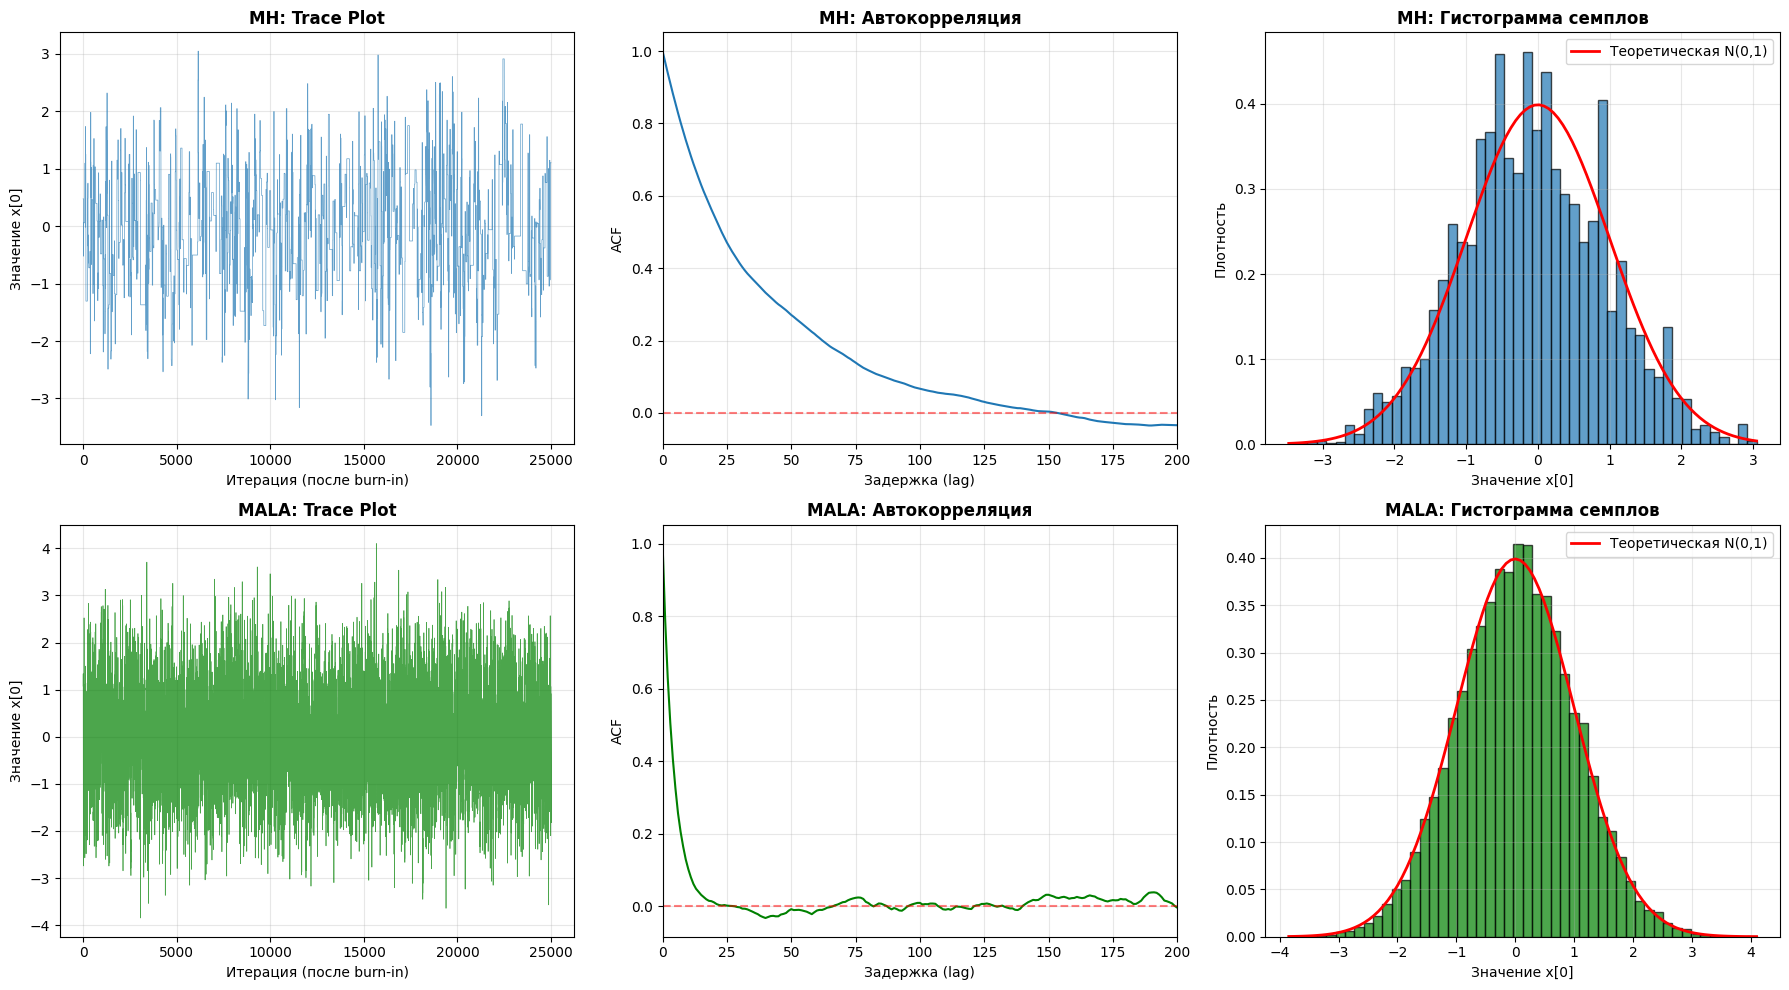


Визуализация для размерности 0
MH: среднее = -0.0750, std = 1.0062
MALA: среднее = 0.0217, std = 0.9899
Теоретическое: среднее = 0.0, std = 1.0


In [9]:
import matplotlib.pyplot as plt

dim = 0

# Функция для вычисления ACF
def compute_acf(x, max_lag=200):
    """Вычисляет автокорреляционную функцию"""
    x = x - x.mean()
    n = len(x)
    acf = np.zeros(max_lag + 1)
    acf[0] = 1.0
    
    for lag in range(1, max_lag + 1):
        if lag < n:
            acf[lag] = np.corrcoef(x[:-lag], x[lag:])[0, 1]
    
    return acf

max_lag = 200
mh_acf = compute_acf(mh_chain_burned[:, dim], max_lag)
mala_acf = compute_acf(mala_chain_burned[:, dim], max_lag)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(mh_chain_burned[:, dim], alpha=0.7, linewidth=0.5)
axes[0, 0].set_title('MH: Trace Plot', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Итерация (после burn-in)')
axes[0, 0].set_ylabel(f'Значение x[{dim}]')
axes[0, 0].grid(True, alpha=0.3)

lags = np.arange(max_lag + 1)
axes[0, 1].plot(lags, mh_acf, linewidth=1.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('MH: Автокорреляция', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Задержка (lag)')
axes[0, 1].set_ylabel('ACF')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, max_lag)

axes[0, 2].hist(mh_chain_burned[:, dim], bins=50, density=True, alpha=0.7, edgecolor='black')

x_theory = np.linspace(mh_chain_burned[:, dim].min(), mh_chain_burned[:, dim].max(), 100)
y_theory = np.exp(-0.5 * x_theory**2) / np.sqrt(2 * np.pi)
axes[0, 2].plot(x_theory, y_theory, 'r-', linewidth=2, label='Теоретическая N(0,1)')
axes[0, 2].set_title('MH: Гистограмма семплов', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel(f'Значение x[{dim}]')
axes[0, 2].set_ylabel('Плотность')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(mala_chain_burned[:, dim], alpha=0.7, linewidth=0.5, color='green')
axes[1, 0].set_title('MALA: Trace Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Итерация (после burn-in)')
axes[1, 0].set_ylabel(f'Значение x[{dim}]')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(lags, mala_acf, linewidth=1.5, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('MALA: Автокорреляция', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Задержка (lag)')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, max_lag)

axes[1, 2].hist(mala_chain_burned[:, dim], bins=50, density=True, alpha=0.7, 
                edgecolor='black', color='green')
x_theory = np.linspace(mala_chain_burned[:, dim].min(), mala_chain_burned[:, dim].max(), 100)
y_theory = np.exp(-0.5 * x_theory**2) / np.sqrt(2 * np.pi)
axes[1, 2].plot(x_theory, y_theory, 'r-', linewidth=2, label='Теоретическая N(0,1)')
axes[1, 2].set_title('MALA: Гистограмма семплов', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel(f'Значение x[{dim}]')
axes[1, 2].set_ylabel('Плотность')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nВизуализация для размерности {dim}")
print(f"MH: среднее = {mh_chain_burned[:, dim].mean():.4f}, std = {mh_chain_burned[:, dim].std():.4f}")
print(f"MALA: среднее = {mala_chain_burned[:, dim].mean():.4f}, std = {mala_chain_burned[:, dim].std():.4f}")
print(f"Теоретическое: среднее = 0.0, std = 1.0")
